In [1]:
from mnist import MNIST
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import cv2
import sklearn.datasets as dataset
from sklearn.mixture import GaussianMixture
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d import Axes3D

from itertools import product, combinations
import os
import scipy.stats as stat

import sklearn
import sklearn.datasets as dataset

from matplotlib import cm
# import plotly.express as px
%matplotlib inline  

### GMM Algorithm

In [10]:
def gmm_algorithm_univariate(iterations,P_em,K,clas):

    """GMM ALGORITHM
    Input : 
    iterations -- Maximum no. of iterations
    P_em       -- dictionary that contains mean, variances and weightages of all mixture components
    K          -- no. of mixture components
    clas       -- input data
    Return: 
    P_em -- Updated dictionary that contains mean, variances and weightages of all mixture components
    res_coeff  -- contains the responsibility coefficient of all images w.r.t each mixture
    log_likey  -- contains log likelihood of each iteration
    
    """
    
    
    ll_old=0
    ll_new=0
    log_likely= np.zeros((iterations,1))
    
    for itr in range(iterations):  
        #responsibility coefficient of size(no. of images in a clas x mixture components)
        res_coeff=np.zeros((len(clas),K))  
        
        for n in range(len(clas)):
            res_coeff_nr=np.zeros((1,K))       #to store respob. coeff of each mixture component
            xn=clas[n]
            for k in range(K):
                
                #store the mean and variance of kth mixture component 
                mu=P_em["mean"+str(k)] 
                var=P_em["variance"+str(k)]
                var=np.abs(var)
                var_inv=1/(var+0.01) #added 0.01 to avoid 'nan'(undefined)  np.linalg.inv(var)
                
                #(1/(2*pi*var)^(1/2))*exp(-x^2/(2*var))
                fx_pi=1/(np.sqrt(2*np.pi*(var+0.01)))
                fx_var=(1/(np.sqrt(var+0.01)))
                muSmu=((xn-mu)*(xn-mu)*var_inv)/2
                f_x_k=fx_pi*np.exp(-muSmu)  
                
                #gamma_nk numerator=lamda_k*gaussian(x_n,theta_k)
                
                res_coeff_nr[0,k]=P_em["lamda"][k]*f_x_k 
            
            # respob. coeff of nth input w.r.t kth mixture
            #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
            res_coeff[n,:]=res_coeff_nr/(np.sum(res_coeff_nr)+1e-50) 

        #EXPECTATION - STEP
        
        #sum of gamma_nk over-all n for each k
        N_k=np.sum(res_coeff,axis=0) 
       
        for k in range(K):
            
            res_coeff_k=res_coeff[:,k]
            res_coeff_k=np.reshape(res_coeff_k,(1,len(clas)))
            
            #MAXIMISATION - STEP
            #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
            
            #mean=(sum(gamma_nk*x_n))(over all n)/sum(gamma_nk) (over all n)
            P_em["mean"+str(k)]=(res_coeff_k@clas[:])/(N_k[k]+1e-50)
            
            #var= (sum(gamma_nk*(x_n-mean_k)^2)(over all n)/sum(gamma_nk) (over all n)
            var_temp=clas[:]-P_em["mean"+str(k)]
            var_temp=np.array(var_temp)
            var_temp=np.abs(var_temp*var_temp)
            
            #update variance of kth mixture component
            P_em["variance"+str(k)]=(res_coeff_k@(var_temp))/(N_k[k]+1e-10)
            
         
        
        #update lamda
        P_em["lamda"]=N_k/len(clas)


        """Below code is find the log likelihood for the parameters obtained in the current iteration"""


        ll=0
        for n in range(len(clas)):
            xi=clas[n]
            lh=0
            for k in range(K):
                #store the mean and variance of kth mixture component 
                mu=P_em["mean"+str(k)] 
                var=P_em["variance"+str(k)]
                var=np.abs(var)
                var_inv=1/(var+0.01) #added 0.01 to avoid 'nan'(undefined)  np.linalg.inv(var)
                
                #(1/(2*pi*var)^(1/2))*exp(-x^2/(2*var))
                fx_pi=1/(np.sqrt(2*np.pi*(var+0.01)))
                fx_var=(1/(np.sqrt(var+0.01)))
                muSmu=((xi-mu)*(xi-mu)*var_inv)/2
                f_x_k=fx_pi*np.exp(-muSmu)  
                
                #gamma_nk numerator=lamda_k*gaussian(x_n,theta_k)
                
                lh=lh+P_em["lamda"][k]*f_x_k 
                
#                 mu=P_em["mean"+str(k)]  #stores the mean of kth component
#                 var=P_em["variance"+str(k)]
#                 var=np.abs(var)
#                 var_inv=1/(var+1e-50) #np.linalg.inv(var)
#                 fx_pi=np.log((2*np.pi)*var+0.99)*0.5
#                 #fx_var=(1/(np.sqrt(var+1e-50)))
#                 muSmu=((xi-mu)*var_inv*(xi-mu))/2
                
#                 f_x_k=fx_pi-muSmu  
                #ll_update=res_coeff[n,k]*f_x_k
                #ll_update=res_coeff[n,k]*(f_x_k+np.log(P_em["lamda"][k]+0.01)) #(xi@p_i.T+(1-xi)@(p_i_minus).T
                #ll=ll+ll_update
            #print(lh)
            ll=ll+np.log(lh)
#         print(ll)
        ll_old=ll_new
        ll_new=ll
        log_likely[itr]=ll_new


        
        if (np.abs(ll_new-ll_old)<0.1 and itr>=1):
            #log_likely[itr+1:iterations]=log_likely[itr]
            print(f"For iteration {itr} the difference between new log likelihood and old log likelihood is less than 0.1")
            break
    
    return log_likely,P_em,res_coeff,itr



### GMM for Univariate Gaussian 

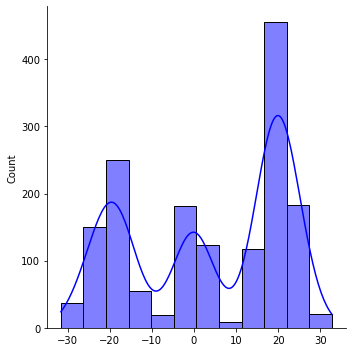

For iteration 4 the difference between new log likelihood and old log likelihood is less than 0.1


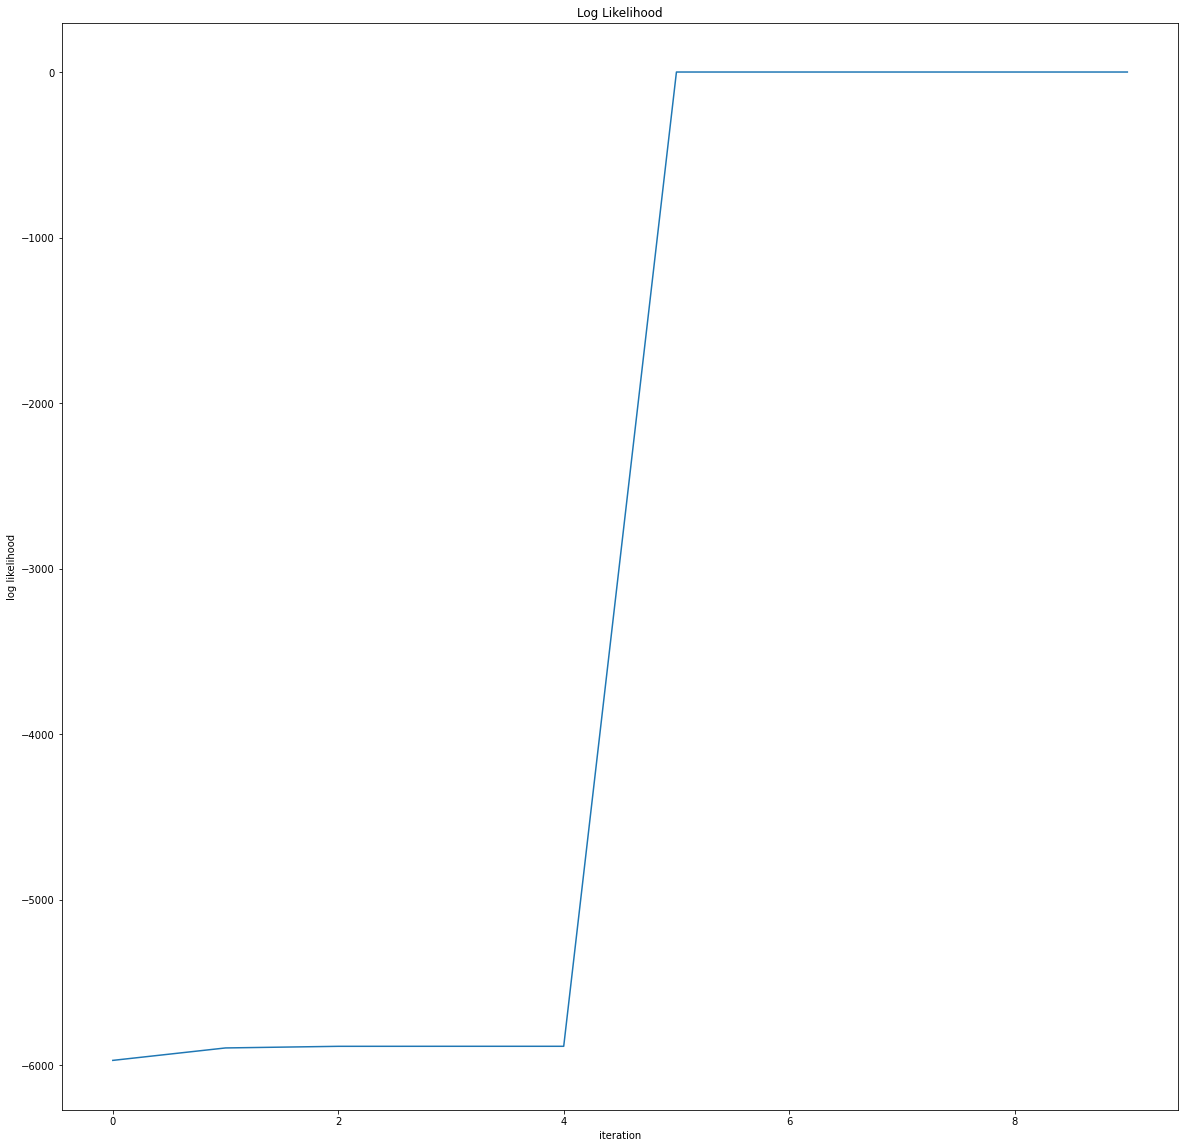

For component 0  true mean is -20.0: and variance is 15
For component 1  true mean is 0.0: and variance is 8
For component 2  true mean is 20.0: and variance is 12
For component 0 mean is : -0.1618937738202576 , variance is : 6.92240040558849 and the weight is : 0.20172138283413588
For component 1 mean is : 20.04687944949306 , variance is : 12.098499257304349 and the weight is : 0.489625835583871
For component 2 mean is : -19.95485630773358 , variance is : 15.071574481853876 and the weight is : 0.3086527815819941

Plot Gaussian Distribution using the estimated parameters


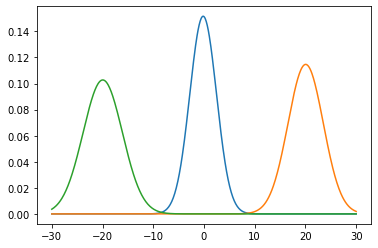

In [80]:

K = 3     # Number of mixture components in univariate GMM 
N = 1600 # Number of samples to be drawn from univariate GMM
iterations=10
means     = np.linspace(-20, 20, num=K)
variances = np.array([15,8,12])#np.linspace(3,6, num=K)
lambdas   = [0.3,0.2,0.5]

samples_lst=0
for n in range(N):
    mix_no=np.random.choice(3,p=lambdas)
    sample= np.random.normal(loc = means[mix_no],scale = np.sqrt(variances[mix_no]))
    samples_lst=np.append(samples_lst,sample)
#     samples_lst= [np.random.normal(loc = means[k],scale = np.sqrt(variances[k]),size = int(N//2)) for k in range(K)]
#     samples     = np.expand_dims(np.array([item for sublist in samples_lst for item in sublist]),axis=1)
sns.displot(samples_lst, color='b',kde=True)   #kde=True to get the desnity estimate
plt.hist(samples_lst, bins =10,density=True)
plt.show()

P=dict()

#initialise lamda's=1/K
phi=np.ones((1,K))*(1/K)  #np.random.dirichlet(alpha)  #to genereate lamda values such that they sum to 1
P["lamda"]=phi [0,:]       #pi[0,:]

#random initialisation of mean and variance
for k in range(K):
    P["mean"+str(k)]= -20+40*np.random.rand()
    P["variance"+str(k)]= 5+ 5*np.random.rand()

# print(samples.shape)
# print(means.shape)
# print(variances.shape)
log_likely,P,res_coeff,itera=gmm_algorithm_univariate(iterations,P,K,samples_lst)
plt.figure(figsize=(20,20))
plt.title("Log Likelihood")
#plt.axis('off')

plt.plot(log_likely)#plt.plot(np.linspace(1,iter_convg,iter_convg),log_likehood[:iter_convg])  #np.linspace(1,iterations,iterations),
plt.xlabel("iteration")
plt.ylabel("log likelihood")
plt.show()

for i in range(K):
    print(f"For component {i}  true mean is {means[i]}: and variance is {variances[i]}")
#     print(np.squeeze(P["mean"+str(i)]),end=' , variance is : ')
#     print(np.squeeze(P["variance"+str(i)]),end=' and the weight is : ')
#     print(np.squeeze(P["lamda"][i]))


for i in range(K):
    print(f"For component {i} mean is : ",end='')
    print(np.squeeze(P["mean"+str(i)]),end=' , variance is : ')
    print(np.squeeze(P["variance"+str(i)]),end=' and the weight is : ')
    print(np.squeeze(P["lamda"][i]))
    
print("")    
print("Plot Gaussian Distribution using the estimated parameters")

N=600
x=np.linspace(np.min(means)-10,np.max(means)+10,N)
for i in range(K):
    var_k=P["variance"+str(i)]
    std_dev=np.sqrt(var_k)
    loc1=P["mean"+str(i)]
#     scale=std_dev
    z=stat.norm.pdf(x,loc1,std_dev)
    plt.plot(x,z)
plt.show()


In [12]:
# gm=GaussianMixture(n_components=K, random_state=0).fit(samples)
# print(gm.covariances_,gm.means_,gm.weights_,gm.n_iter_)
# dim = 2  # dimension of random vector
# K = 4    # Number of components in univariate GMM 
# N = 1000 # Number of samples from multivariate GMM

In [13]:
def gmm_algorithm_mulivariate(iterations,P_em,K,clas):

    """GMM ALGORITHM
    Input : 
    iterations -- Maximum no. of iterations
    P_em       -- dictionary that contains parameters and weightages of all mixture components
    K          -- no. of mixture components
    
    Return: 
    P_em -- Updated dictionary that contains parameters and weightages of all mixture components
    res_coeff  -- contains the responsibility coefficient of all images w.r.t each mixture
    log_likey  -- contains log likelihood of each iteration
    
    """
    
    
    ll_old=0
    ll_new=0
    log_likely= np.zeros((iterations,1))
    d=clas.shape[1]
    N=clas.shape[0]
    
    for itr in range(iterations):  
        #responsibility coefficient of size(no. of samples in clas x mixture components)
        res_coeff=np.zeros((N,K))  
        
        for n in range(N):
            res_coeff_nr=np.zeros((1,K))       #to store respob. coeff of each mixture component
            xn=clas[n][:]
            xn=np.reshape(xn,(d,1))
            #print(xn.shape)
            for k in range(K):
                
                mu=P_em["mean"+str(k)]  #stores the mean of kth component
                mu=np.reshape(mu,(d,1))
                var=P_em["variance"+str(k)]
                var=np.abs(var)
                #below code is to find Gaussian(x_n,theta_k)

                var_inv=np.abs(np.linalg.inv(var+np.identity(d)*0.01))
                fx_pi=1/(np.sqrt((2*np.pi)))**(d)
                fx_var=np.abs(np.linalg.det(var+np.identity(d)*0.01))
                
                fx_var=np.abs(1/np.sqrt(fx_var))
                muSmu=((xn-mu).T@var_inv@(xn-mu))/2
                
                
                f_x_k=fx_pi*fx_var*np.exp(-muSmu)
                
                #update the responsibility coefficient for kth component
                res_coeff_nr[0,k]=P_em["lamda"][k]*f_x_k
                #print(f"value of res : {res_coeff_nr[0,:]}, {itr}")
           

            # respob. coeff of nth sample with kth mixture
            #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
            res_coeff[n,:]=res_coeff_nr/(np.sum(res_coeff_nr)+1e-50) 
            

        #EXPECTATION - STEP    
        N_k=np.sum(res_coeff,axis=0) 

        #update the lamda parameter for all mixture components
        P_em["lamda"]=N_k/N #len(clas)
#         P_em["lamda"]=P_em["lamda"]/np.sum(P_em["lamda"])
        #print(np.sum(P_em["lamda"]))
    
        #print(f"Value of {np.sum(N_k)},{itr}")
        #below code is to update the mean and variances for the mixture components
        for k in range(K):
            mean_temp=np.zeros((1,d))
            for n in range(N):
                xi=clas[n,:]
                xi=np.reshape(xi,(1,d))
                
                res_coeff_k=res_coeff[n,k]
                #MAXIMISATION - STEP
                mean_temp= mean_temp+(res_coeff_k*xi)

            P_em["mean"+str(k)]= mean_temp/(N_k[k]+1e-50)
        
        for k in range(K):
            var_temp=np.zeros((d,d))
            mu_new=P_em["mean"+str(k)]
            for n in range(N):
                xi=clas[n,:]
                xi=np.reshape(xi,(1,d))
                res_coeff_k=res_coeff[n,k]
                #res_coeff_k=np.reshape(res_coeff_k,(1,len(clas)))
                
                #MAXIMISATION - STEP
                #added 1e-50 to the denominator so that responsibility coefficient doesn't become undefined value (0/0 form)
                xi_mu=xi-mu_new
                xi_mu=np.reshape(xi_mu,(d,1))
                sigma_new=np.outer(xi_mu,xi_mu)
                
                var_temp= var_temp+np.abs((res_coeff_k*(sigma_new)))
            
            #update the mean and variances of kth class
            
            
            P_em["variance"+str(k)]= np.abs(var_temp)/(N_k[k]+1e-50)
            
     


        """Below code is find the log likelihood for the parameters obtained in the current iteration"""
        ll=0
        for n in range(N):
            x=clas[n][:]
            x=np.reshape(x,(d,1))
            lh=0
            for k in range(K):
                
                mu=P_em["mean"+str(k)]  #stores the mean of kth component
                mu=np.reshape(mu,(d,1))
                var=np.abs(P_em["variance"+str(k)])
               
                var_inv=np.abs(np.linalg.inv(var+np.identity(d)*1e-5)) #to avoid singularity
                fx_pi=1/(np.sqrt((2*np.pi)))**(d)
                fx_var=np.abs(1/(np.linalg.det(var+np.identity(d)*1e-5)))
                fx_var=np.sqrt(fx_var)
                muSmu=((x-mu).T@var_inv@(x-mu))/2
                
                f_x_k=fx_pi*fx_var*np.exp(-muSmu)
                
                #f_x_k=np.log(fx_pi)+np.log(fx_var)-muSmu
                
                #ll_update=P_em["lamda"][k]*(f_x_k) #np.log(P_em["lamda"][k]+0.01)) #(xi@p_i.T+(1-xi)@(p_i_minus).T
                lh=lh+P_em["lamda"][k]*f_x_k
            ll=ll+np.log(lh+0.01)

        ll_old=ll_new
        ll_new=ll
#       print(f"log likelihood : {ll_new},old : {ll_old}")

        log_likely[itr]=ll_new


        
#         if (abs(ll_new-ll_old)<1 and itr>=1):
#             #log_likely[itr+1:iterations]=log_likely[itr]
#             print(f"For iteration {itr} the difference between new log likelihood and old log likelihood is less than 1")
#             break
    
    return log_likely,P_em,res_coeff,itr



In [14]:
def k_means_init(K,iteration_max,samples):
    iterations=iteration_max   #no. of iterations
    K=K
    z=np.random.randint(0,K,size=(samples.shape[0],1))
    tot_err=np.zeros((iterations,1))
    d=samples.shape[1]   #dimesnion of the data
    N=samples.shape[0]   #size of the data
    
    for itr in range(iterations):
        mu=np.zeros((K,d))
        covariance=[np.zeros((d,d)) for i in range(K)]

        #print(np.shape(covariance))
        xi_s=samples            
        xi_s=np.array(xi_s)

        #print(np.shape(xi_s))
        err=np.zeros((K,1))
        for k in range(K):
            mean_temp=np.zeros((1,d))
            var_temp=np.zeros((d,d))

            zd=np.where(z==k,1,0)
            for n in range(N):

                #find the mean value of kth mixture component using the samples that belong to the kth mixture in ith class
                mean_temp=mean_temp+(zd[n]*xi_s[n,:])
                mean_temp=np.reshape(mean_temp,(1,d))
    #             x_mu=xi_s[n,:]-mu[k,:]
    #             #print(x_mu.shape)
    #             var_temp=(x_mu@x_mu.T)
    #             #var_temp=var_temp.reshape(2,600,2,600).sum(axis=(1,3))
    #             var_temp=var_temp+z_d[n]*var_temp
    #             #var_temp

            #print(np.sum(z_d),k)
            #update the mean values
            mu[k,:]=mean_temp/(np.sum(zd))    

            #below code is to find the covaraince and total erro
            for n in range(N):
                x_mu=xi_s[n,:]-mu[k,:]
                #print(x_mu.shape)
                var_temp=(x_mu@x_mu.T)
                #var_temp=var_temp.reshape(2,600,2,600).sum(axis=(1,3))
                var_temp=var_temp+zd[n]*var_temp
                #var_temp
            covariance[k][:,:]=var_temp/np.sum(zd)


            error=zd.T@(xi_s-mu[k,:])
            err[k]=err[k]+np.linalg.norm(error)

        #total error for each iteration
        tot_err[itr]=np.sum(err)

        #below code is to re-assignments of samples to different bins(mixture components)
        n=0   
        for n in range(len(xi_s)):
            xn=xi_s[n][:]-mu
            #print(np.shape(xn))
            min_dist=np.linalg.norm(xn,axis=1)

            z[n]=np.argmin(min_dist)  #store the distance  that is minimum among all the mixture components 

        #print(min_dist)

        z[n]=np.argmin(min_dist)
        #print(min_dist)



        if total_err<1e-20:
          #print(f"The iteration no. at which the total_err is less than 1e-20 is {total_err}: corresponding iteration is {itr}")
          break
    return mu,covariance

### Run Below  cell to run GMM for Multivariate case

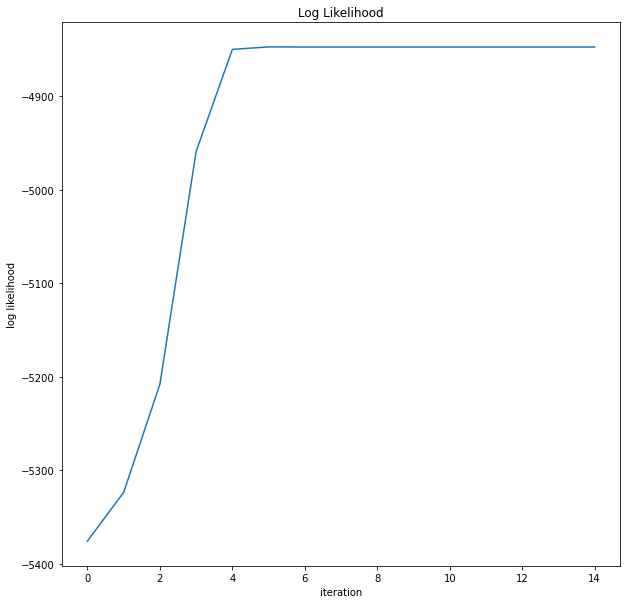

For component 0  true mean is [2 2]: and covariance is [[5 0]
 [0 4]]
For component 1  true mean is [10 10]: and covariance is [[4 0]
 [0 6]]
For some component mean is : [9.99657183 9.94757115] , variance is : [[3.90200743 3.25208087]
 [3.25208087 6.37863146]] and the weight is : 0.5991562068561024
For some component mean is : [1.89381842 1.9342065 ] , variance is : [[5.5229091  2.89153448]
 [2.89153448 3.82260309]] and the weight is : 0.400843793143898
[2 2]


<ipython-input-88-5e4d52f473ae>:108: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = fig.gca(projection='3d')
<ipython-input-88-5e4d52f473ae>:108: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.gca(projection='3d')


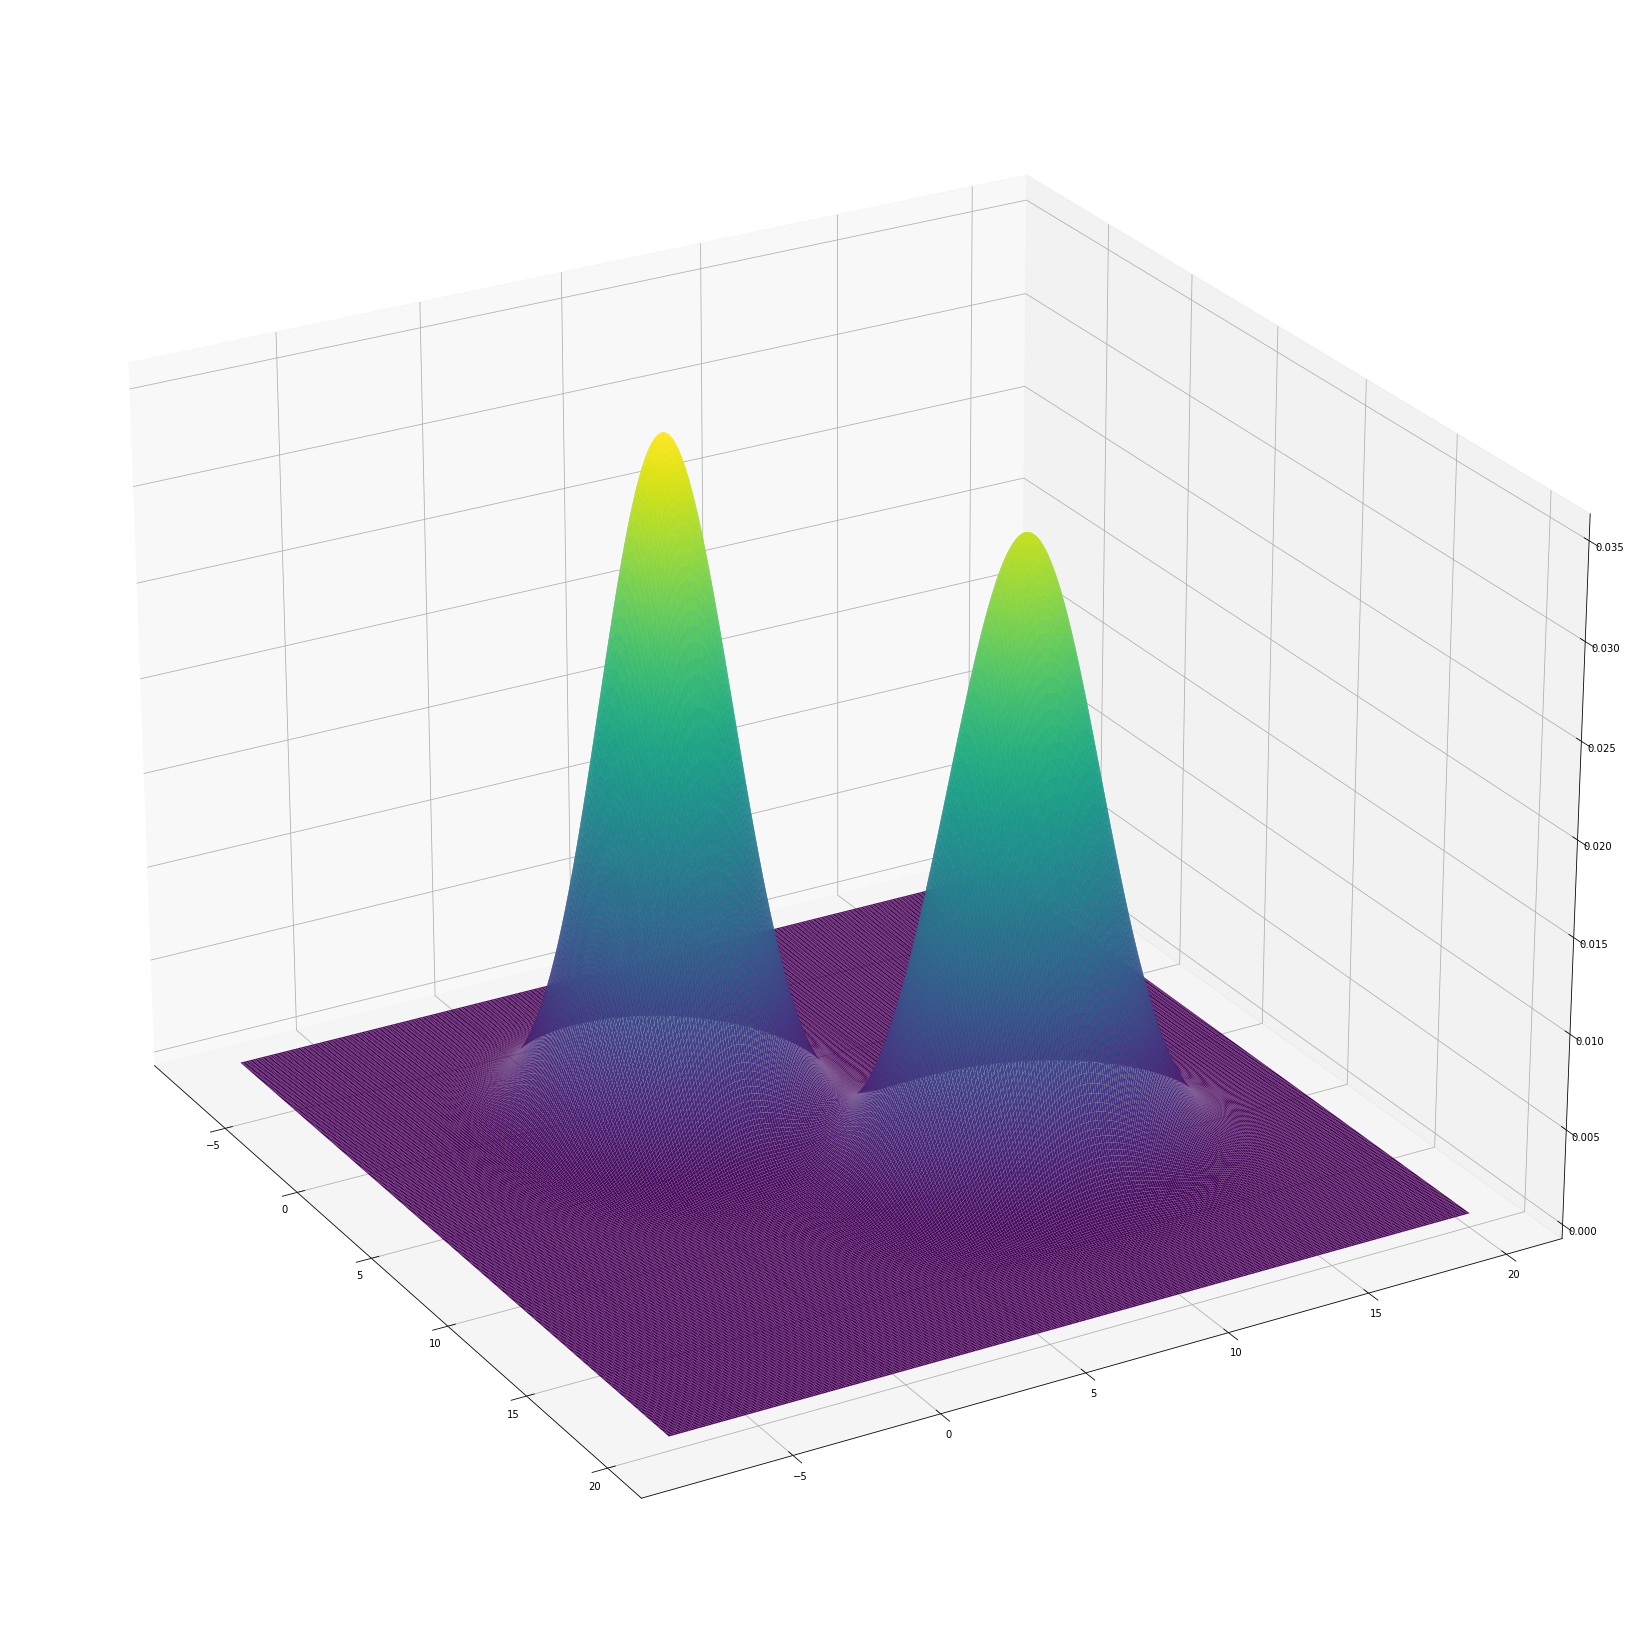

[9.99657183 9.94757115]


<ipython-input-88-5e4d52f473ae>:140: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = fig.gca(projection='3d')
<ipython-input-88-5e4d52f473ae>:140: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.gca(projection='3d')


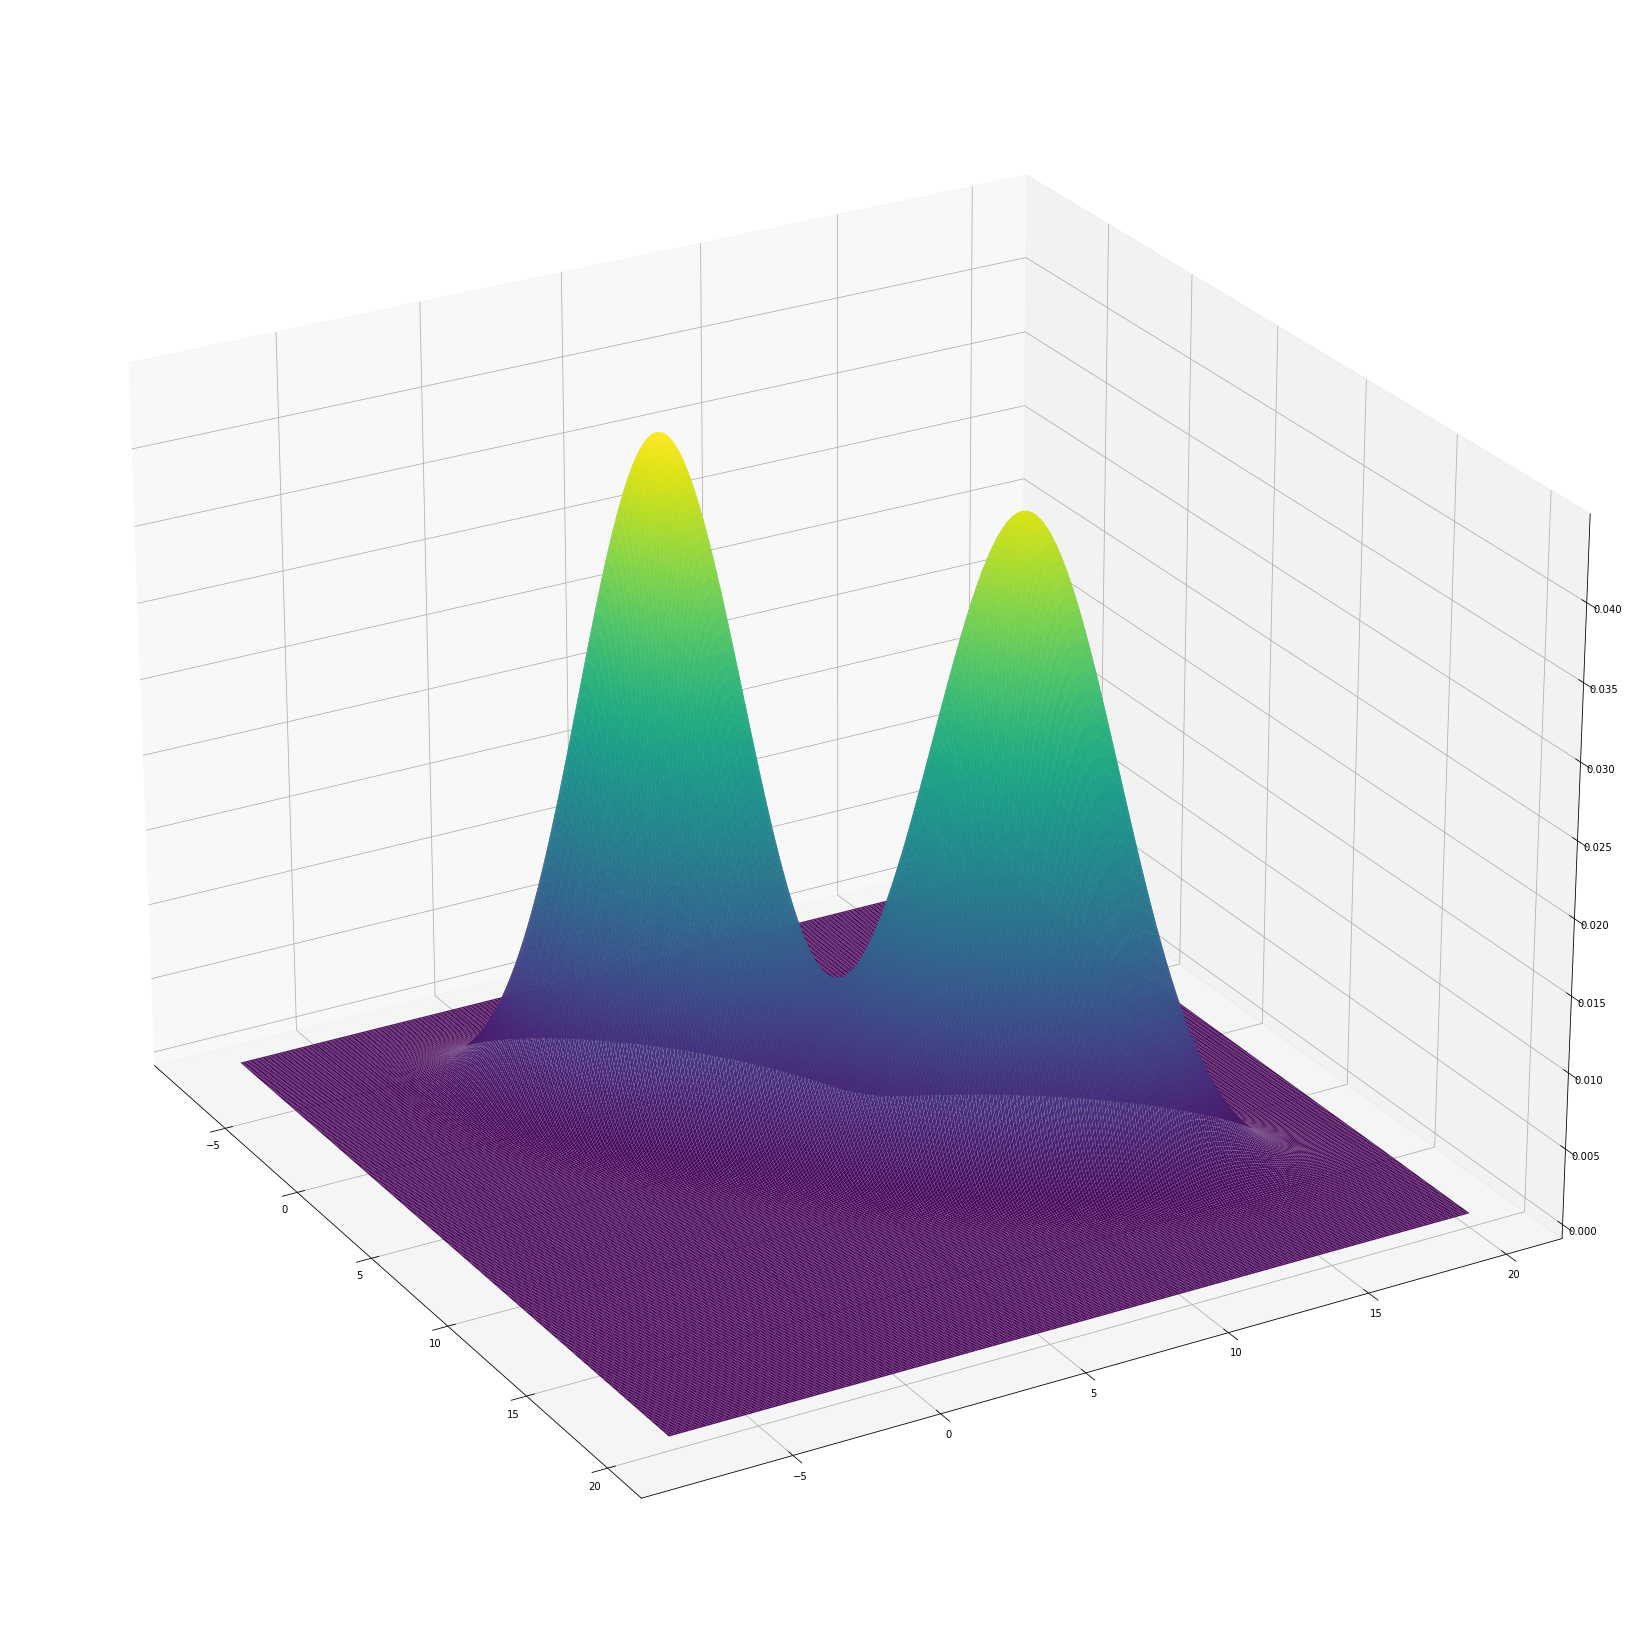

In [88]:
K = 2    # Number of mixture components in univariate GMM 
N = 1200 # Number of samples to be drawn from each mixture of mulitvariate Gaussian to construct the mixture density 
iterations=15
d=2     #dimenion of the data
mean=np.zeros((K,d))
  
covariance=[]


#"""Below code is to generate the mean vector and covariance matrix for the mixture components"""
#mean[0,:]= 0
# covariance_temp= np.ones((d,d))*5
# covariance.append(covariance_temp) #np.linspace(3,6, num=K)
    
# samples_temp=np.random.multivariate_normal(mean[0,:],covariance_temp)
# samples=np.array(samples_temp)
mean=np.array([[2,2],[10,10]])

covariance_temp=np.array([[5,0],[0,4]])
covariance.append(covariance_temp) 

covariance_temp=np.array([[4,0],[0,6]])
covariance.append(covariance_temp) 


# for k in range(K):
#    mean[k,:]= np.array(mean[k,:])  # -20+40*np.array()#np.random.rand(1,d)
#     covariance_temp= dataset.make_spd_matrix(d)
#     covariacne_temp=10+5*np.abs(covariance_temp)
    #np.linspace(3,6, num=K)

true_covar=covariance
lambdas   = [0.4,0.6]


samples_lst=np.random.multivariate_normal(mean[0,:],covariance[0])
samples_lst=np.reshape(samples_lst,(1,d))
for n in range(N-1):
    mix_no=np.random.choice(2,p=lambdas)
    sample= np.random.multivariate_normal(mean[mix_no,:],covariance[mix_no])
    sample=np.reshape(sample,(1,d))
    samples_lst=np.append(samples_lst,sample,axis=0)


P={}
#random initialisation of parameters
phi=np.ones((1,K))*(1/K)  #np.random.dirichlet(alpha)  #to genereate lamda values such that they sum to 1
P["lamda"]=phi [0,:]       #pi[0,:]

#means,covarinace= k_means_init(K,2,samples)
for k in range(K):
    P["mean"+str(k)]= 1+6*np.random.rand(1,d)
    P["variance"+str(k)]=2+np.random.rand(1)*np.identity(d)

# print(samples.shape)
# print(means.shape)
# print(variances.shape)
#print(samples_lst.shape)
log_likely,P,res_coeff,itera=gmm_algorithm_mulivariate(iterations,P,K,samples_lst)
plt.figure(figsize=(10,10))
plt.title("Log Likelihood")
#plt.axis('off')

plt.plot(log_likely)#plt.plot(np.linspace(1,iter_convg,iter_convg),log_likehood[:iter_convg])  #np.linspace(1,iterations,iterations),
plt.xlabel("iteration")
plt.ylabel("log likelihood")
plt.show()

# print(mean)
# print(covariance)

for i in range(K):
    print(f"For component {i}  true mean is {mean[i]}: and covariance is {covariance[i]}")

for i in range(K):
    print(f"For some component mean is : ",end='')
    print(np.squeeze(P["mean"+str(i)]),end=' , variance is : ')
    print(np.squeeze(P["variance"+str(i)]),end=' and the weight is : ')
    print(np.squeeze(P["lamda"][i]))



N=1000
samples_test=np.zeros((N,d))
x= np.linspace(np.min(mean)-10,np.max(mean)+10,N)
y= np.linspace(np.min(mean)-10,np.max(mean)+10,N)


X, Y = np.meshgrid(x,y)
#print(samples_test.shape)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

mu_k=mean[0,:].ravel()
print(mu_k)
Z = multivariate_normal.pdf(pos, mu_k ,covariance[0])
for k in range(K-1):
    
    mu_k=mean[k+1,:]
    mu_k=mu_k.ravel()
    Z =Z+ multivariate_normal.pdf(pos, mu_k, covariance[k+1])

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(30,30))

plt.title("Actual Mixture Model",fontsize=20)
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1,cmap=cm.viridis)
ax.view_init(25,-30)
plt.show()

N=1000
samples_test=np.zeros((N,d))
x= np.linspace(np.min(mean)-10,np.max(mean)+10,N)
y= np.linspace(np.min(mean)-10,np.max(mean)+10,N)


X, Y = np.meshgrid(x,y)
#print(samples_test.shape)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

mu_k=P["mean"+str(0)].ravel()
mu_k=mu_k.ravel()
print(mu_k)
Z = multivariate_normal.pdf(pos, mu_k ,P["variance"+str(0)])
for k in range(K-1):
    
    mu_k=P["mean"+str(k+1)]
    mu_k=mu_k.ravel()
    Z =Z+ multivariate_normal.pdf(pos, mu_k, P["variance"+str(k+1)])

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(30,30))

plt.title("Estimated Mixture Model using GMM",fontsize=20)
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1,cmap=cm.viridis)
ax.view_init(25,-30)
plt.show()


### K-Means for Question 2

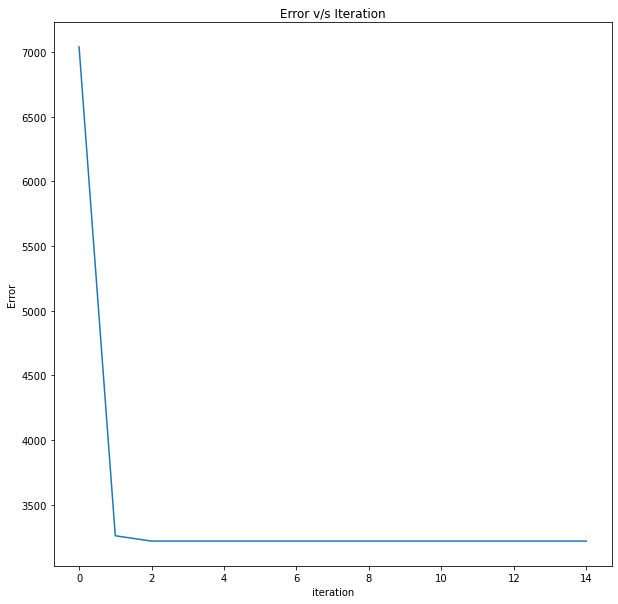

For component 0  true mean is [2 2]: and covariance is [[5 0]
 [0 4]]
For component 1  true mean is [10 10]: and covariance is [[4 0]
 [0 6]]
For some component predicted mean is [2.00260106 1.98103974]: and covariance is [[5.07580097 2.6612505 ]
 [2.6612505  3.48479035]]
For some component predicted mean is [10.04160992 10.02830998]: and covariance is [[3.78677132 3.05521335]
 [3.05521335 6.09037959]]
[2 2]


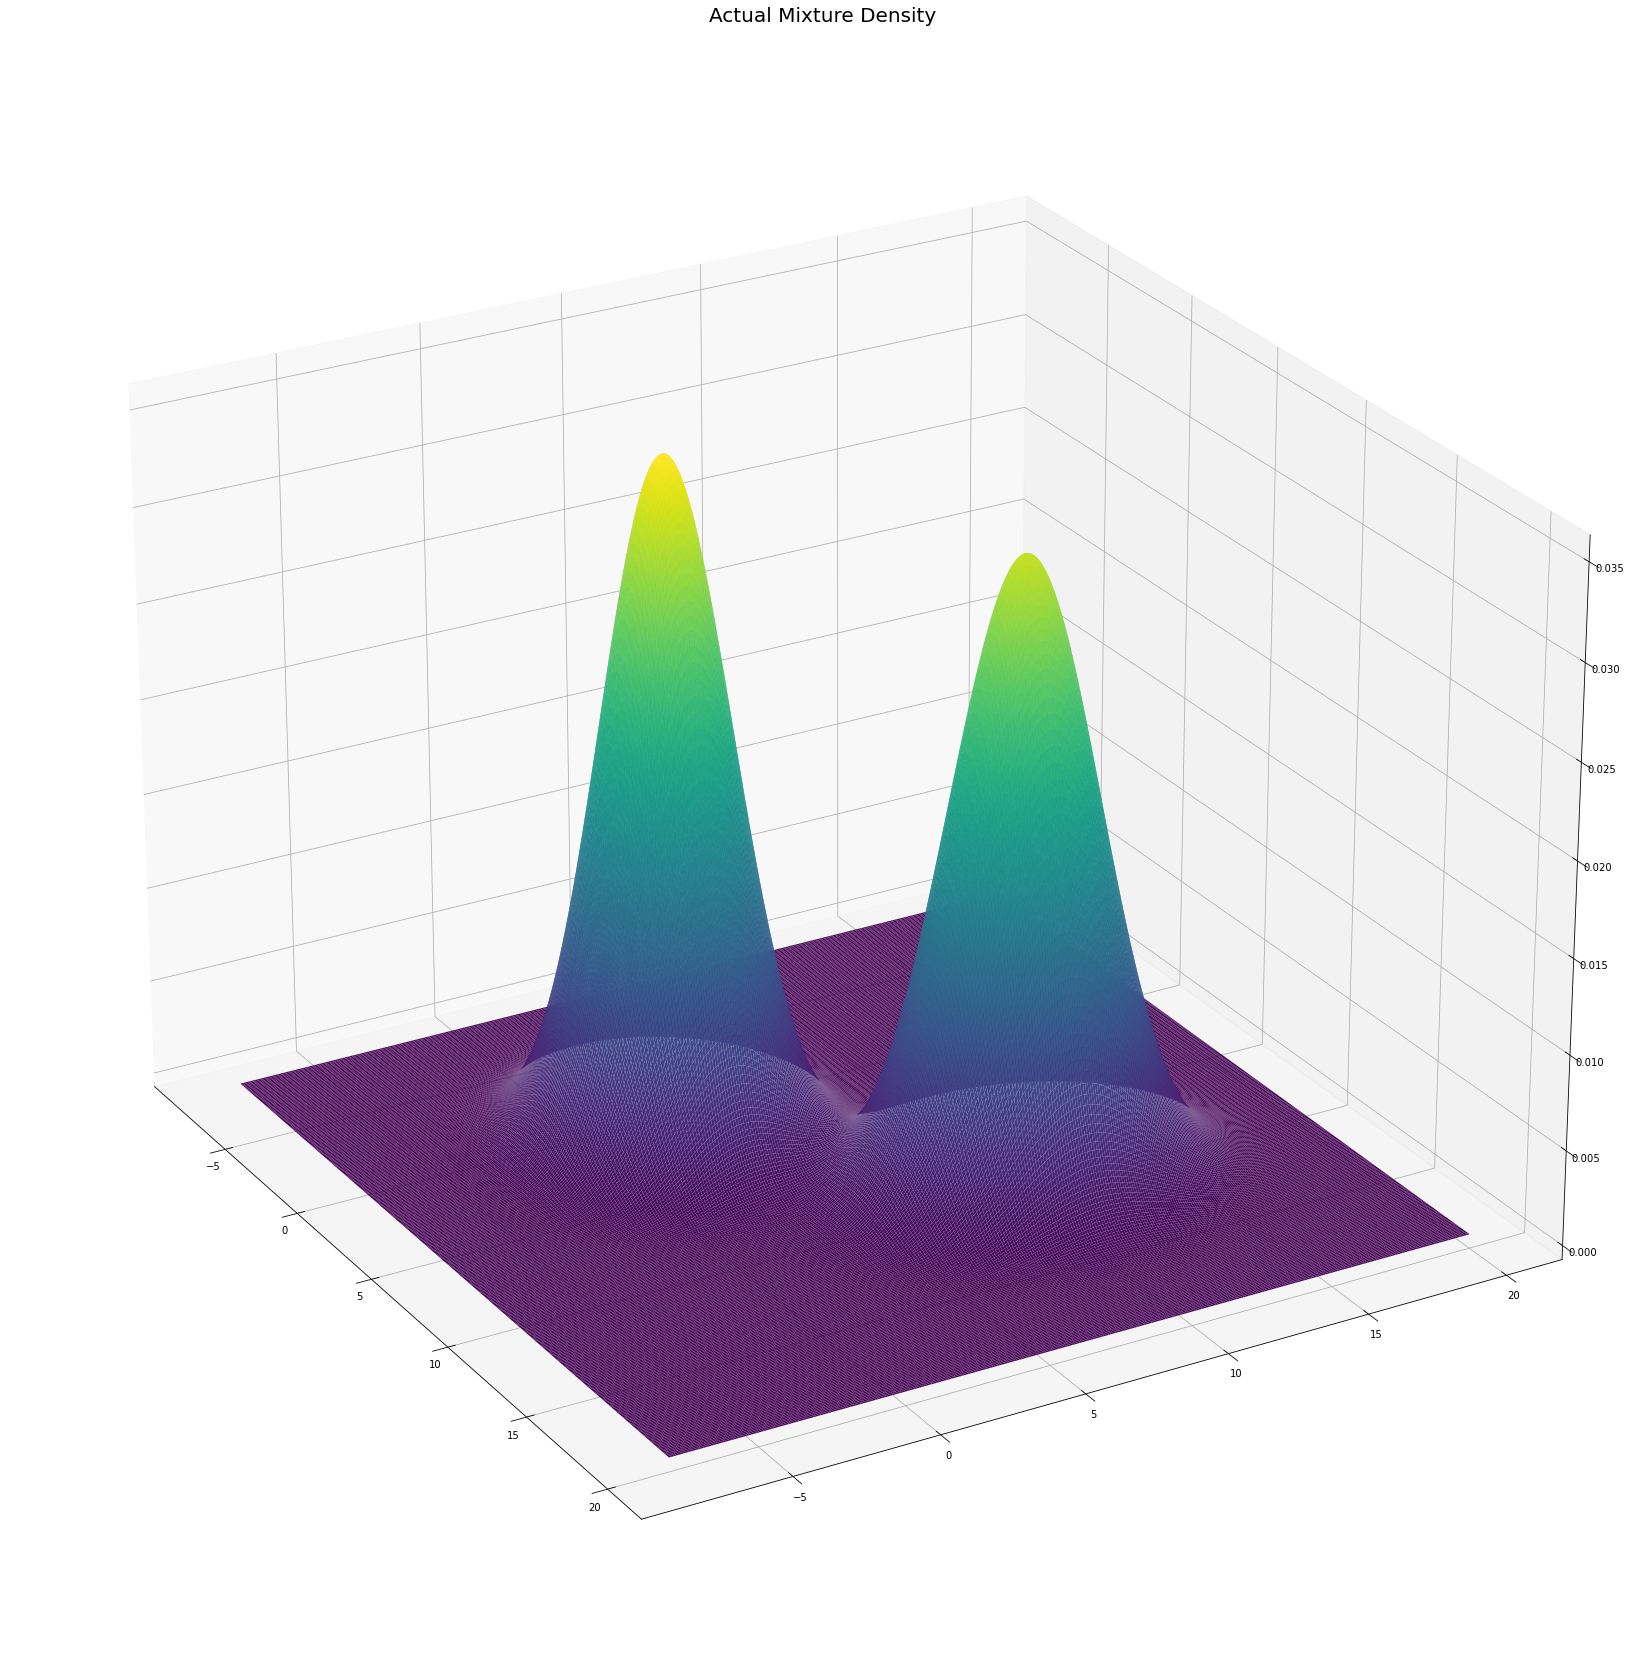

[2.00260106 1.98103974]


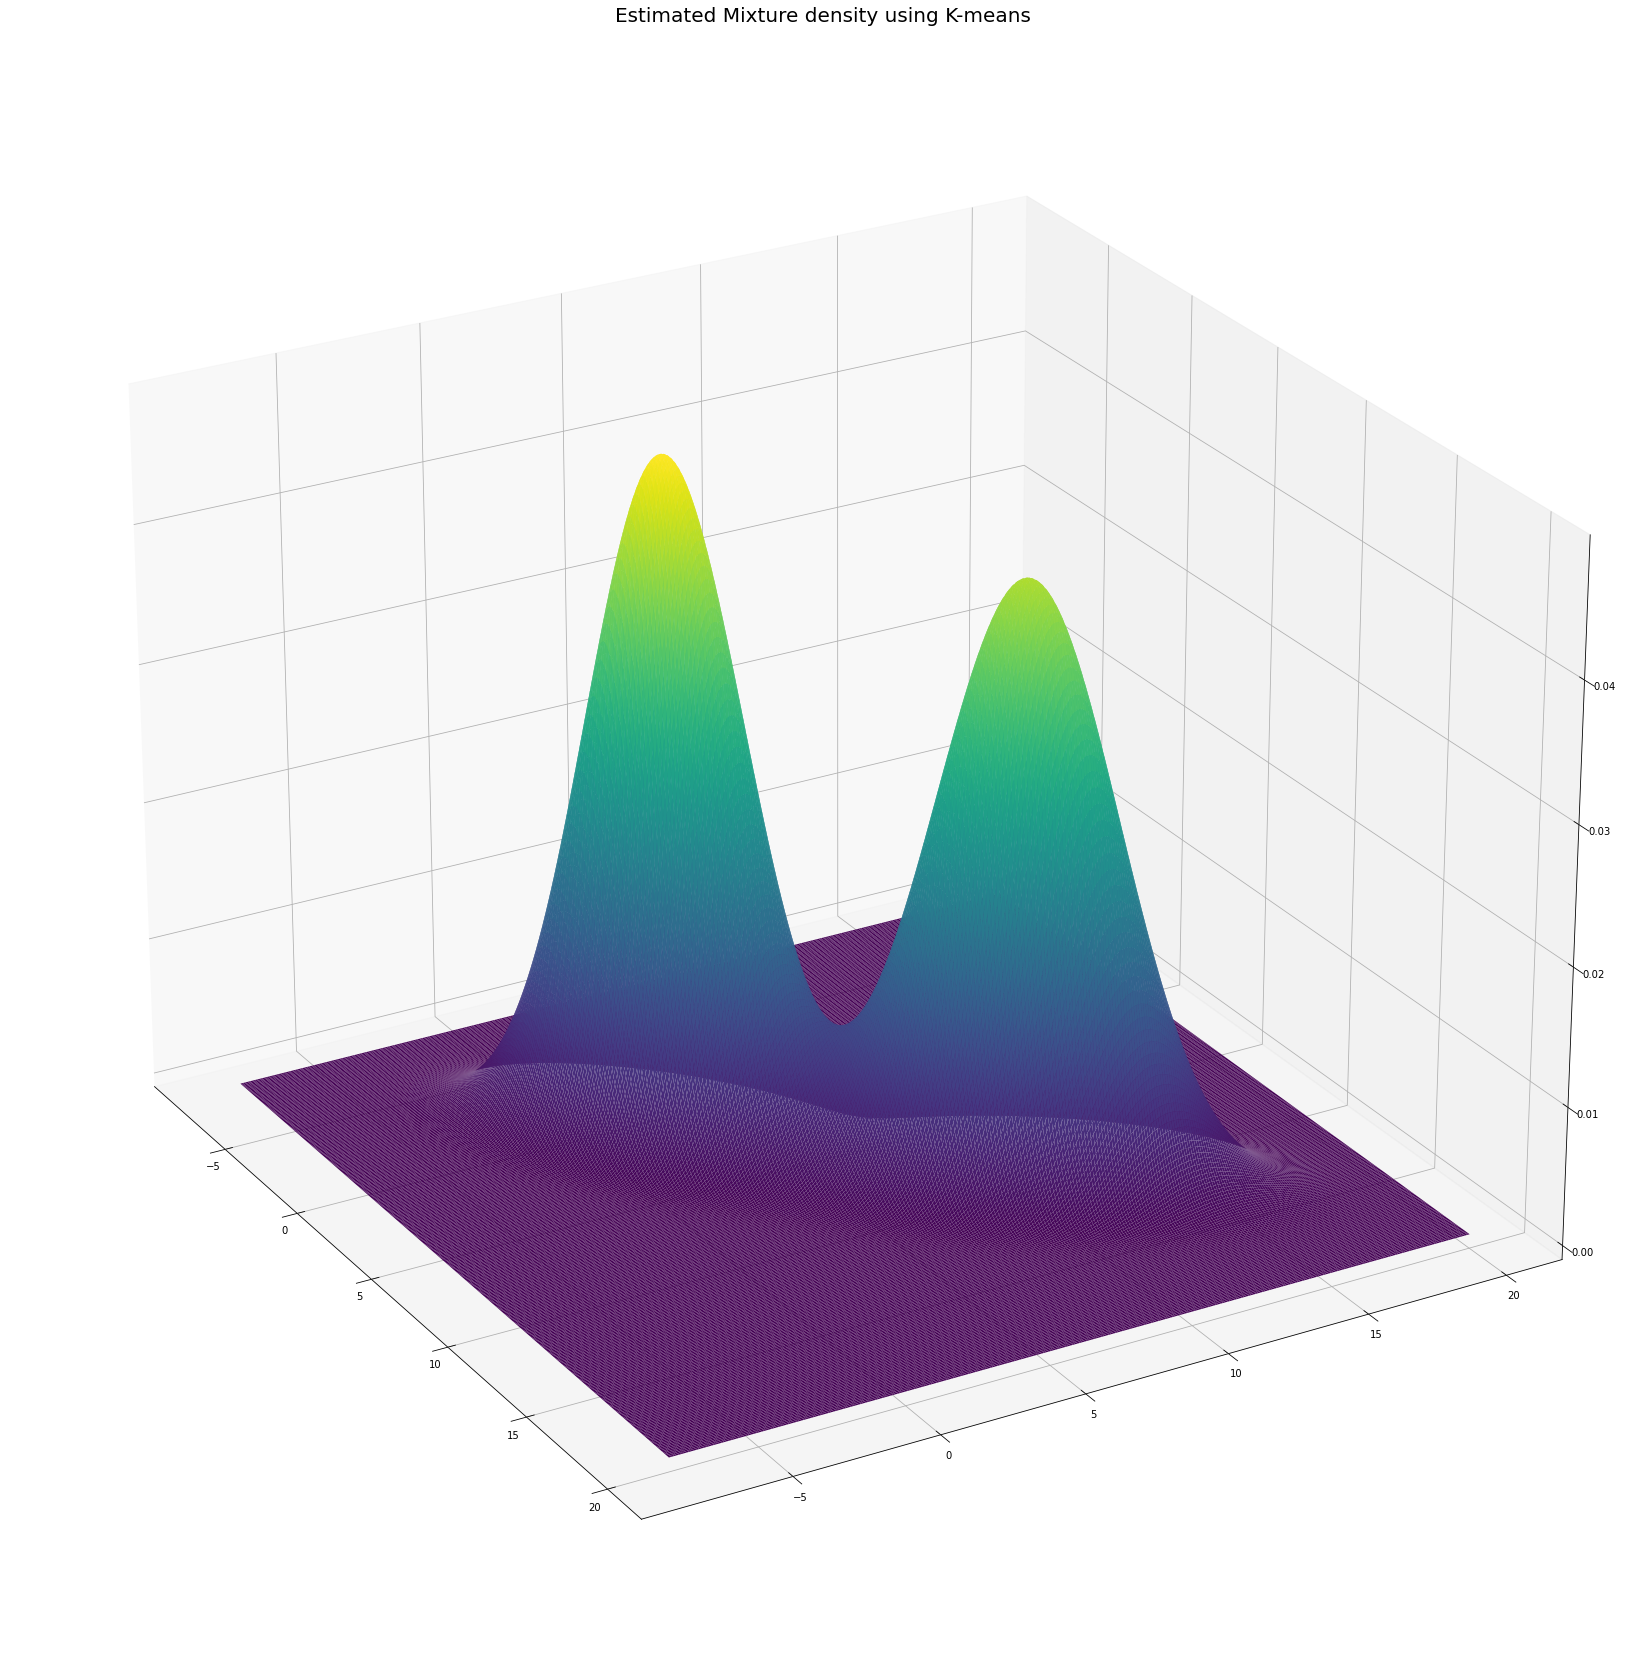

In [87]:
K = 2    # Number of mixture components in univariate GMM 
N = 1200 # Number of samples to be drawn from each mixture of mulitvariate Gaussian to construct the mixture density 
iterations=15
d=2     #dimenion of the data
mean=np.zeros((K,d))
  
covariance=[]


#"""Below code is to generate the mean vector and covariance matrix for the mixture components"""
#mean[0,:]= 0
# covariance_temp= np.ones((d,d))*5
# covariance.append(covariance_temp) #np.linspace(3,6, num=K)
    
# samples_temp=np.random.multivariate_normal(mean[0,:],covariance_temp)
# samples=np.array(samples_temp)
mean=np.array([[2,2],[10,10]])

covariance_temp=np.array([[5,0],[0,4]])
covariance.append(covariance_temp) 

covariance_temp=np.array([[4,0],[0,6]])
covariance.append(covariance_temp) 


# for k in range(K):
#    mean[k,:]= np.array(mean[k,:])  # -20+40*np.array()#np.random.rand(1,d)
#     covariance_temp= dataset.make_spd_matrix(d)
#     covariacne_temp=10+5*np.abs(covariance_temp)
    #np.linspace(3,6, num=K)

true_covar=covariance
lambdas   = [0.4,0.6]


samples_lst=np.random.multivariate_normal(mean[0,:],covariance[0])
samples_lst=np.reshape(samples_lst,(1,d))
for n in range(N-1):
    mix_no=np.random.choice(2,p=lambdas)
    sample= np.random.multivariate_normal(mean[mix_no,:],covariance[mix_no])
    sample=np.reshape(sample,(1,d))
    samples_lst=np.append(samples_lst,sample,axis=0)


true_covar=covariance


z=np.random.randint(0,K,size=(samples_lst.shape[0],1))
tot_err=np.zeros((iterations,1))
d=samples_lst.shape[1]   #dimesnion of the data
N=samples_lst.shape[0]   #size of the data

#true_covar=covariance
for itr in range(iterations):
    mu=np.zeros((K,d))
    covariance=np.zeros((K,d,d))
    
    err=np.zeros((K,1))
    for k in range(K):
        mean_temp=np.zeros((1,d))
        var_temp=np.zeros((d,d))
        
        zd=np.where(z==k,1,0)
        for n in range(N):
            xn=samples_lst[n,:]
            #find the mean value of kth mixture component using the samples that belong to the kth mixture in ith class
            mean_temp=mean_temp+(zd[n]*xn)
            mean_temp=np.reshape(mean_temp,(1,d))
        
        mu[k,:]=mean_temp/(np.sum(zd))
        for n in range(N):
            xn=samples_lst[n,:]
            #find the mean value of kth mixture component using the samples that belong to the kth mixture in ith class
            x_mu=xn-mu[k,:]
            x_mu=np.reshape(x_mu,(d,1))
            
            var_temp=var_temp+zd[n]*np.abs(np.outer(x_mu,x_mu))
            #var_temp
        covariance[k,:,:]=var_temp/np.sum(zd)
    
    err_itr=0
    for n in range(N):
        xn=samples_lst[n,:]
      
        for k in range(K):
            zd=np.where(z==k,1,0)
            norm_val=np.linalg.norm(xn-mu[k,:])
            
            err_itr=err_itr + zd[n]*norm_val
    
    #total error for each iteration
    tot_err[itr]=err_itr

    #below code is to re-assignments of samples to different bins(mixture components)
    n=0   
    for n in range(N):
        xn=samples_lst[n][:]-mu
        #print(np.shape(xn))
        min_dist=np.linalg.norm(xn,axis=1)

        z[n]=np.argmin(min_dist)  #store the distance  that is minimum among all the mixture components 
    
    #print(min_dist)

    z[n]=np.argmin(min_dist)
    #print(min_dist)
    
#     if err_itr<1:
#       print(f"The iteration no. at which the total_err is less than 1e-20 is {total_err}: corresponding iteration is {itr}")
#       break

plt.figure(figsize=(10,10))
plt.title("Error v/s Iteration")
#plt.axis('off')

plt.plot(tot_err)#plt.plot(np.linspace(1,iter_convg,iter_convg),log_likehood[:iter_convg])  #np.linspace(1,iterations,iterations),
plt.xlabel("iteration")
plt.ylabel("Error")
plt.show()


for i in range(K):
    print(f"For component {i}  true mean is {mean[i]}: and covariance is {true_covar[i]}")
for i in range(K):
    print(f"For some component predicted mean is {mu[i]}: and covariance is {covariance[i]}")

N=1000
samples_test=np.zeros((N,d))
x= np.linspace(np.min(mean)-10,np.max(mean)+10,N)
y= np.linspace(np.min(mean)-10,np.max(mean)+10,N)


X, Y = np.meshgrid(x,y)
#print(samples_test.shape)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

mu_k=mean[0,:].ravel()
print(mu_k)
Z = multivariate_normal.pdf(pos, mu_k ,true_covar[0])
for k in range(K-1):
    
    mu_k=mean[k+1,:]
    mu_k=mu_k.ravel()
    Z =Z+ multivariate_normal.pdf(pos, mu_k, true_covar[k+1])


# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(30,30))

ax = fig.gca(projection='3d')
plt.title("Actual Mixture Density",fontsize=20)
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1,cmap=cm.viridis)
ax.view_init(25,-30)
plt.show()

N=1000
samples_test=np.zeros((N,d))
x= np.linspace(np.min(mean)-10,np.max(mean)+10,N)
y= np.linspace(np.min(mean)-10,np.max(mean)+10,N)


X, Y = np.meshgrid(x,y)
#print(samples_test.shape)
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

mu_k=mu[0,:].ravel()

print(mu_k)
Z = multivariate_normal.pdf(pos, mu_k ,covariance[0])
for k in range(K-1):
    
    mu_k=mu[k+1,:]
    mu_k=mu_k.ravel()
    Z =Z+ multivariate_normal.pdf(pos, mu_k, covariance[k+1])


# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=(30,30))
ax = fig.gca(projection='3d')
plt.title("Estimated Mixture density using K-means",fontsize=20)
ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1,cmap=cm.viridis)
ax.view_init(25,-30)
plt.show()


In [ ]:
#ignore this code for this question
# def gaussian_density(mu,var,x):
    
#     n=var.shape[1]
#     var_inv=np.linalg.inv(var)
#     f_x_temp=(1/(2*pi)**(n//2))*(1/(np.linalg.det(var))**(n//2))
#     muSmu=(mu.T@var_inv@mu)/2
#     f_x_k=f_x_temp*np.exp(-muSmu)           #to find pi^xi  
    
#     return f_x_k
    